In [1]:
import sys
import numpy as np
np.random.seed(0)
import torch
import pylab
from sklearn.metrics import confusion_matrix
import itertools
from debug_visualisation import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler

# Main code for Concrete Dropout

In [2]:
import keras.backend as K
from keras import initializers
from keras.engine import InputSpec
from keras.layers import Dense, Lambda, Wrapper, Concatenate


class ConcreteDropout(Wrapper):
    """This wrapper allows to learn the dropout probability for any given input layer.
    ```python
        # as the first layer in a model
        model = Sequential()
        model.add(ConcreteDropout(Dense(8), input_shape=(16)))
        # now model.output_shape == (None, 8)
        # subsequent layers: no need for input_shape
        model.add(ConcreteDropout(Dense(32)))
        # now model.output_shape == (None, 32)
    ```
    `ConcreteDropout` can be used with arbitrary layers, not just `Dense`,
    for instance with a `Conv2D` layer:
    ```python
        model = Sequential()
        model.add(ConcreteDropout(Conv2D(64, (3, 3)),
                                  input_shape=(299, 299, 3)))
    ```
    # Arguments
        layer: a layer instance.
        weight_regularizer:
            A positive number which satisfies
                $weight_regularizer = l**2 / (\tau * N)$
            with prior lengthscale l, model precision $\tau$ (inverse observation noise),
            and N the number of instances in the dataset.
            Note that kernel_regularizer is not needed.
        dropout_regularizer:
            A positive number which satisfies
                $dropout_regularizer = 2 / (\tau * N)$
            with model precision $\tau$ (inverse observation noise) and N the number of
            instances in the dataset.
            Note the relation between dropout_regularizer and weight_regularizer:
                $weight_regularizer / dropout_regularizer = l**2 / 2$
            with prior lengthscale l. Note also that the factor of two should be
            ignored for cross-entropy loss, and used only for the eculedian loss.
    """

    def __init__(self, layer, weight_regularizer=1e-6, dropout_regularizer=1e-5,
                 init_min=0.1, init_max=0.1, is_mc_dropout=True, **kwargs):
        assert 'kernel_regularizer' not in kwargs
        super(ConcreteDropout, self).__init__(layer, **kwargs)
        self.weight_regularizer = weight_regularizer
        self.dropout_regularizer = dropout_regularizer
        self.is_mc_dropout = is_mc_dropout
        self.supports_masking = True
        self.p_logit = None
        self.p = None
        self.init_min = np.log(init_min) - np.log(1. - init_min)
        self.init_max = np.log(init_max) - np.log(1. - init_max)

    def build(self, input_shape=None):
        self.input_spec = InputSpec(shape=input_shape)
        if not self.layer.built:
            self.layer.build(input_shape)
            self.layer.built = True
        super(ConcreteDropout, self).build()  # this is very weird.. we must call super before we add new losses

        # initialise p
        self.p_logit = self.layer.add_weight(name='p_logit',
                                            shape=(1,),
                                            initializer=initializers.RandomUniform(self.init_min, self.init_max),
                                            trainable=True)
        self.p = K.sigmoid(self.p_logit[0])

        # initialise regulariser / prior KL term
        input_dim = np.prod(input_shape[1:])  # we drop only last dim
        weight = self.layer.kernel
        kernel_regularizer = self.weight_regularizer * K.sum(K.square(weight)) / (1. - self.p)
        dropout_regularizer = self.p * K.log(self.p)
        dropout_regularizer += (1. - self.p) * K.log(1. - self.p)
        dropout_regularizer *= self.dropout_regularizer * input_dim
        regularizer = K.sum(kernel_regularizer + dropout_regularizer)
        self.layer.add_loss(regularizer)

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

    def concrete_dropout(self, x):
        '''
        Concrete dropout - used at training time (gradients can be propagated)
        :param x: input
        :return:  approx. dropped out input
        '''
        eps = K.cast_to_floatx(K.epsilon())
        temp = 0.1

        unif_noise = K.random_uniform(shape=K.shape(x))
        drop_prob = (
            K.log(self.p + eps)
            - K.log(1. - self.p + eps)
            + K.log(unif_noise + eps)
            - K.log(1. - unif_noise + eps)
        )
        drop_prob = K.sigmoid(drop_prob / temp)
        random_tensor = 1. - drop_prob

        retain_prob = 1. - self.p
        x *= random_tensor
        x /= retain_prob
        return x

    def call(self, inputs, training=None):
        if self.is_mc_dropout:
            return self.layer.call(self.concrete_dropout(inputs))
        else:
            def relaxed_dropped_inputs():
                return self.layer.call(self.concrete_dropout(inputs))
            return K.in_train_phase(relaxed_dropped_inputs,
                                    self.layer.call(inputs),
                                    training=training)

Using Theano backend.


### Plot function to make sure stuff makes sense:

In [3]:
def plot(reps=None,train_loss=None,valid_loss=None,uncertainty=None,val_acc=None, valid_y=None,preds=None):
    
   fig = pylab.figure() 
   _, (ax1, ax2) = pylab.subplots(1, 2,figsize=(15, 5), sharex=False, sharey=False)
   #Plot loss on training and validation set    
   ax1.plot(reps, train_loss, c='r', label='Training')
   ax1.plot(reps, valid_loss, c='g', label='Validation')
   ax1.set_title('Losses')
   ax1.legend()
   #Plot student confusion matrix
   names = ['Slight-Right-Turn','Sharp-Right-Turn','Move-Forward','Slight-Left-Turn']
   cnf_matrix = confusion_matrix(np.argmax(valid_y,axis=-1), preds)  
   pylab.sca(ax2)
   plot_confusion_matrix(cnf_matrix, classes=names,normalize=False,title='Student confusion matrix')
 
   pylab.show()

# Evaluate Concrete Dropout

In [4]:
nb_epochs = [200]
nb_reps = 50
K_test = 500
batch_size = 128
Q = 2 #24
nb_features = 7
l = 1e-6
D = 4
with open('/home/yannis/Desktop/compress_bnn/data/Wall/usableData/valid_data_2sensors_1dimTarget_70pc.pt','rb') as f:
      valid = torch.load(f)
with open('/home/yannis/Desktop/compress_bnn/data/Wall/usableData/train_data_2sensors.pt','rb') as f:
      train = torch.load(f)

        
   
N = train.shape[0]
X_tr = train[:,0:2]
Y_tr = train[:,2:4]
X_v = valid[:,0:2]
Y_v = valid[:,2:4]

o = np.zeros((len(Y_tr), 4))
o[np.arange(len(Y_tr)), Y_tr.flatten().astype(int)] = 1   
Y_tr = o

o = np.zeros((len(Y_v), 4))
o[np.arange(len(Y_v)), Y_v.flatten().astype(int)] = 1   
Y_v = o

scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_v = scaler.transform(X_v)


 

### Fit function:

In [5]:
from keras.layers import Input, Dense, Lambda, merge
from keras.models import Model
from keras import backend as K

def fit_model(nb_epoch, X, Y, validation_data=None):
    if K.backend() == 'tensorflow':
        K.clear_session()
    N = X.shape[0]
    wd = l**2. / N
    dd = 2. / N
    inp = Input(shape=(Q,))
    x = inp
    """
    x = ConcreteDropout(Dense(nb_features, activation='relu',name='CD1'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    #x = ConcreteDropout(Dense(nb_features, activation='relu'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    x = ConcreteDropout(Dense(D,activation='sigmoid',name='CD2'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    """
    x = ConcreteDropout(Dense(64, activation='relu',name='CD1'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    x = ConcreteDropout(Dense(32, activation='relu',name='CD1b'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    x = ConcreteDropout(Dense(16, activation='relu',name='CD1d'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    x = ConcreteDropout(Dense(8, activation='relu',name='CD1c'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    x = Dense(D,activation='softmax',name='CD2')(x)
    
    out = x 
    model = Model(inp, out)
    
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    assert len(model.layers[1].trainable_weights) == 3  # kernel, bias, and dropout prob
    assert len(model.losses) == 4  # a loss for each Concrete Dropout layer
    if validation_data==None:
        hist = model.fit(X, Y, epochs=nb_epoch, batch_size=batch_size, verbose=0)    
    else:
        hist = model.fit(X, Y, epochs=nb_epoch, batch_size=batch_size, verbose=0, validation_data=validation_data)
    loss = hist.history['loss'][-1]
    return hist,model, -0.5 * loss  # return ELBO up to const.

### Eval function:

In [6]:
def test(Y_true, MC_samples):
    """
    :Y_true: a 2D array of size N x 4
    :MC_samples: a 3D array of size samples K x N x 4
    """
    assert len(MC_samples.shape) == 3
    assert len(Y_true.shape) == 2
    
    k = MC_samples.shape[0]
    N = Y_true.shape[0]
    #Get probability of each class after MC sampling, so that we can get the mean
    
    MC_means = np.sum(MC_samples,axis=0)/float(k)
    MC_pred = np.argmax(MC_means,axis=-1)   
    y_pred = np.argmax(Y_true,axis=-1)
    acc = len(np.where(MC_pred==y_pred)[0])/float(N)*100
    print("\n ( Micro Averaging ) Accuracy: {}".format(acc))

    #For variation ratio
    predictions_per_test_point = np.argmax(MC_samples,axis=-1)
    mode_fx = []
    MC_majVote = np.zeros(MC_pred.shape)
    for i in xrange(N):
        votes, values = np.unique(predictions_per_test_point[:,i], return_counts=True)
        m = np.argmax(votes)
        mode_fx.append((m,values[m]))
        MC_majVote[i] = m
    acc2 = len(np.where(MC_majVote==y_pred)[0])/float(N)*100
    print("\n ( Macro Averaging ) Accuracy: {}".format(acc2))
    
    
        
    return acc, acc2, MC_means, MC_pred, mode_fx

        

#Run experiment


 ( Micro Averaging ) Accuracy: 99.4757536042

 ( Macro Averaging ) Accuracy: 99.4757536042
0.44532634338138927
0.125077513848501
nan
[143 214 287]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  2   0 295   1]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

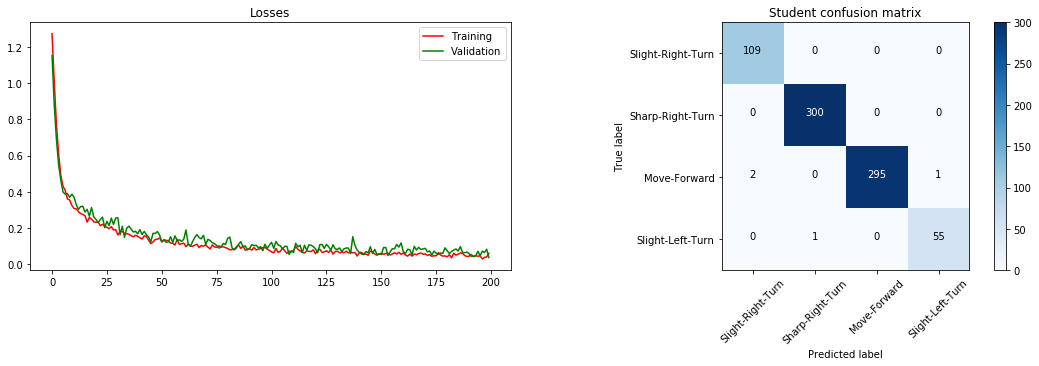


 ( Micro Averaging ) Accuracy: 99.4757536042

 ( Macro Averaging ) Accuracy: 99.4757536042
0.44713761467889906
0.10420317043639417
nan
[143 214 259 287 461 476 658 734]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  3   0 295   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

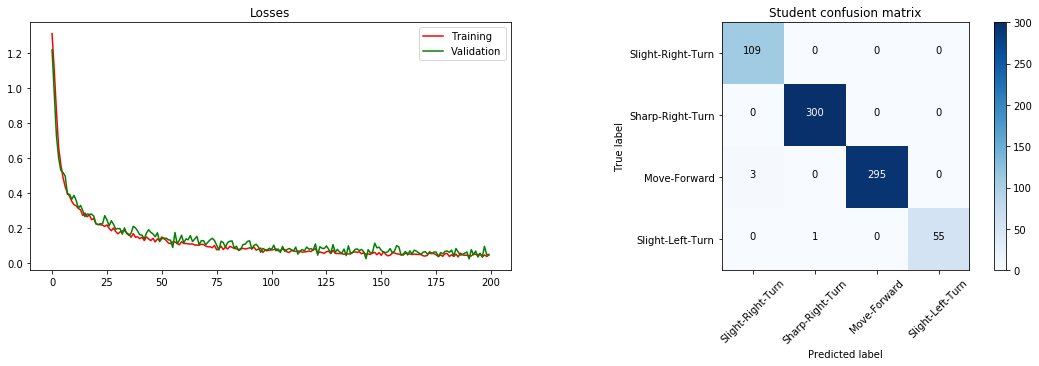


 ( Micro Averaging ) Accuracy: 99.3446920052

 ( Macro Averaging ) Accuracy: 99.3446920052
0.4401100917431192
0.10321484886959371
0.04541117616905923
[]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  3   0 294   1]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

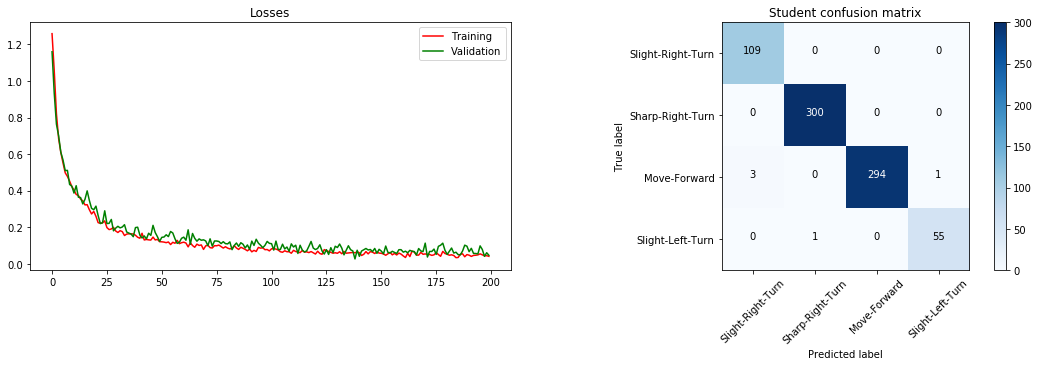


 ( Micro Averaging ) Accuracy: 99.6068152031

 ( Macro Averaging ) Accuracy: 99.6068152031
0.4462385321100918
0.09779266917377437
nan
[143 214 287 461]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  2   0 296   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

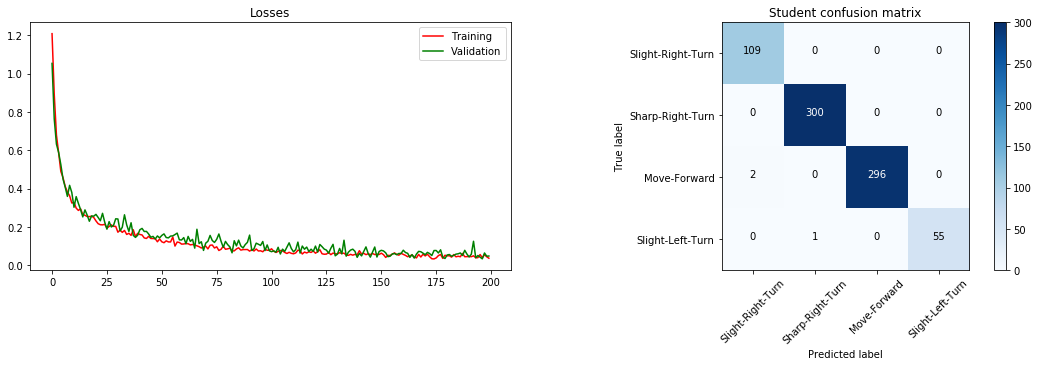


 ( Micro Averaging ) Accuracy: 99.3446920052

 ( Macro Averaging ) Accuracy: 99.3446920052
0.4294128440366972
0.10272606765927056
nan
[143 214 287 461]
Confusion matrix, without normalization
[[107   0   2   0]
 [  0 300   0   0]
 [  1   0 297   0]
 [  0   1   1  54]]


<Figure size 432x288 with 0 Axes>

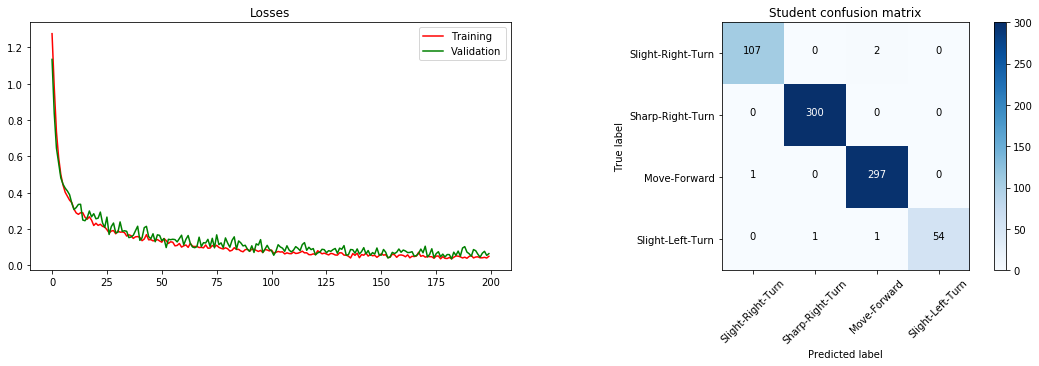


 ( Micro Averaging ) Accuracy: 99.4757536042

 ( Macro Averaging ) Accuracy: 99.4757536042
0.4313813892529489
0.09321996206381061
nan
[143 214 277 287]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  2   0 295   1]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

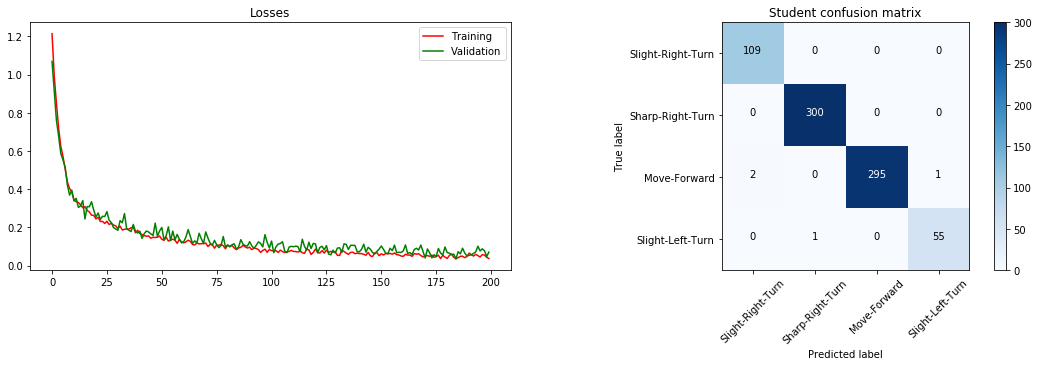


 ( Micro Averaging ) Accuracy: 99.4757536042

 ( Macro Averaging ) Accuracy: 99.4757536042
0.4476225425950196
0.0927583386982409
nan
[143]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  3   0 295   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

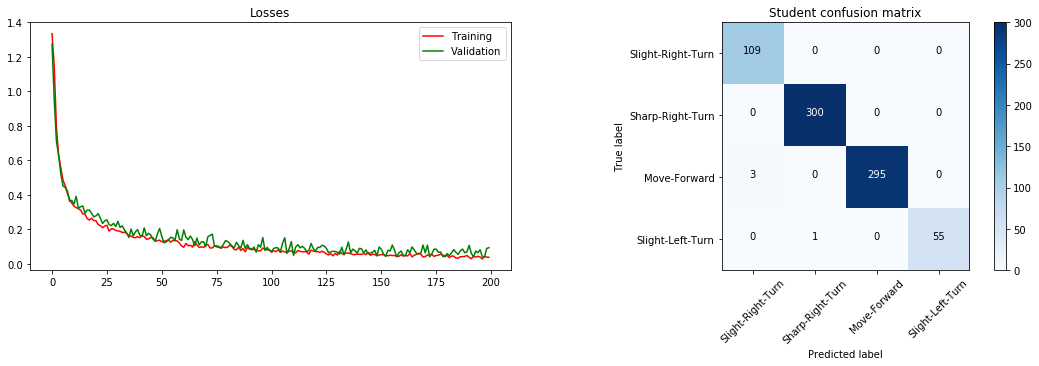


 ( Micro Averaging ) Accuracy: 99.3446920052

 ( Macro Averaging ) Accuracy: 99.3446920052
0.4410249017038008
0.10269452016287987
nan
[143 214 287 461]
Confusion matrix, without normalization
[[106   2   1   0]
 [  0 300   0   0]
 [  0   0 298   0]
 [  0   1   1  54]]


<Figure size 432x288 with 0 Axes>

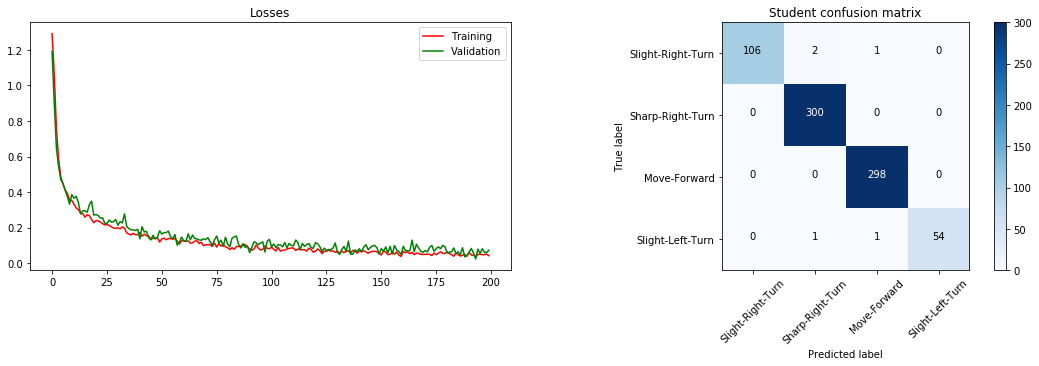


 ( Micro Averaging ) Accuracy: 99.4757536042

 ( Macro Averaging ) Accuracy: 99.4757536042
0.4399816513761468
0.09890147117924722
nan
[143 214 287]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  2   0 296   0]
 [  0   1   1  54]]


<Figure size 432x288 with 0 Axes>

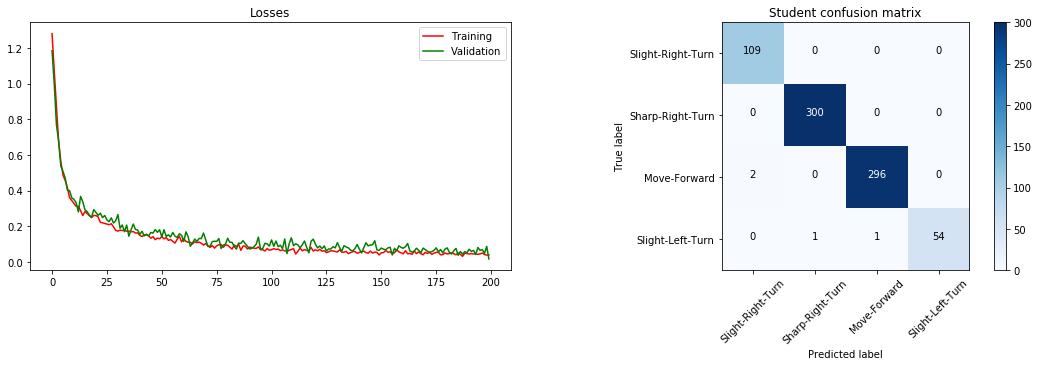


 ( Micro Averaging ) Accuracy: 99.3446920052

 ( Macro Averaging ) Accuracy: 99.3446920052
0.4424639580602884
0.10535694887253748
nan
[143 267 372 461 733]
Confusion matrix, without normalization
[[107   2   0   0]
 [  0 300   0   0]
 [  1   1 296   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

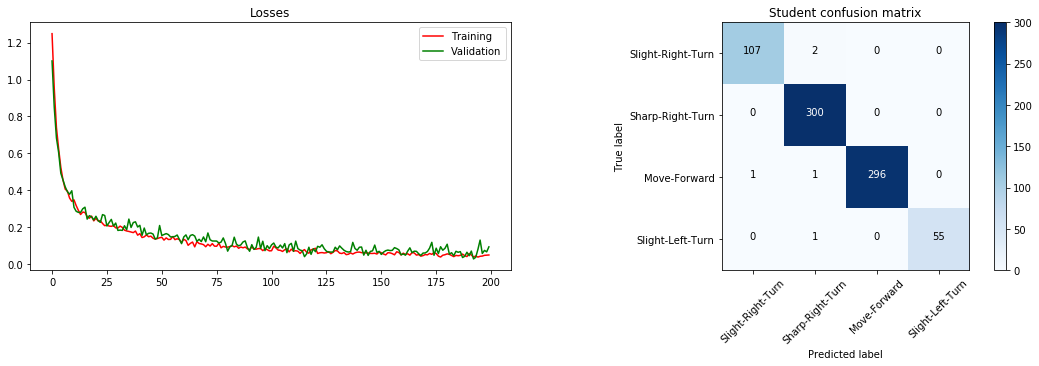


 ( Micro Averaging ) Accuracy: 99.6068152031

 ( Macro Averaging ) Accuracy: 99.6068152031
0.4400629095674968
0.09872654506138392
nan
[ 91 143 213 214 267 271 287 372 452 461 463 588 681 726 733]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  2   0 295   1]
 [  0   0   0  56]]


<Figure size 432x288 with 0 Axes>

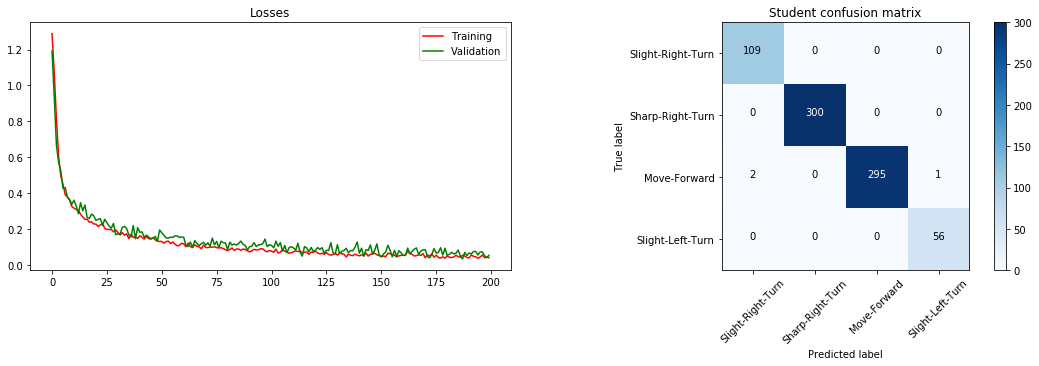


 ( Micro Averaging ) Accuracy: 99.6068152031

 ( Macro Averaging ) Accuracy: 99.6068152031
0.4350694626474443
0.10575884697790383
nan
[ 91 143 213 214 267 277 287 372 452 461 669 681 733]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  1   0 296   1]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

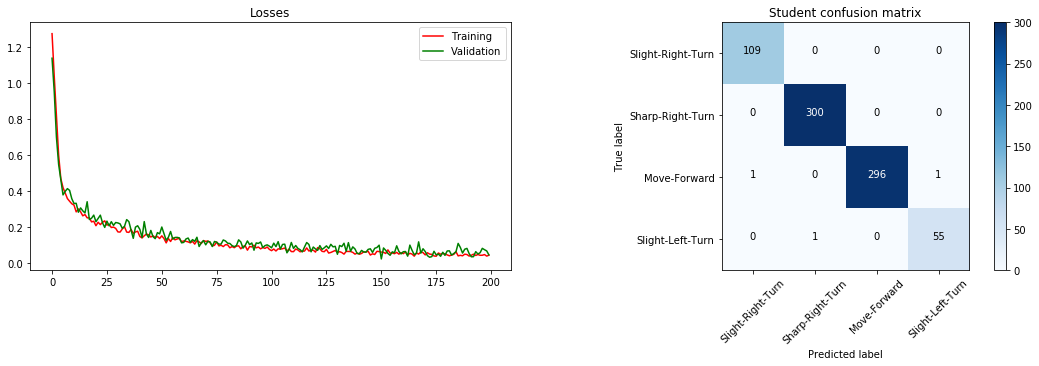


 ( Micro Averaging ) Accuracy: 99.3446920052

 ( Macro Averaging ) Accuracy: 99.3446920052
0.4379868938401048
0.10535473904790915
nan
[143 214 287]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  3   0 294   1]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

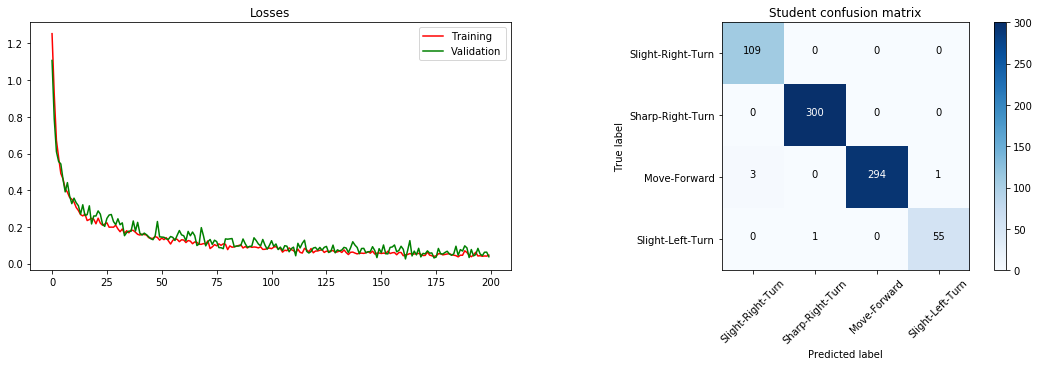


 ( Micro Averaging ) Accuracy: 98.8204456094

 ( Macro Averaging ) Accuracy: 98.8204456094
0.4337273918741808
0.10311486680417042
nan
[143 214 287]
Confusion matrix, without normalization
[[104   0   5   0]
 [  0 298   2   0]
 [  0   0 297   1]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

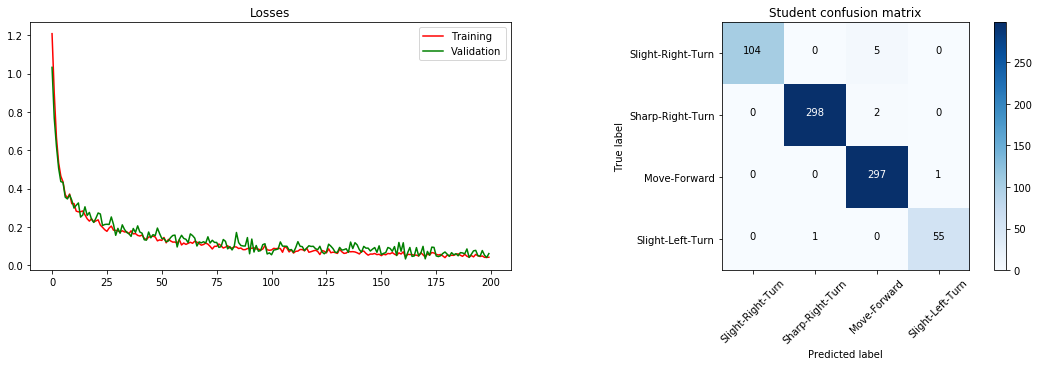


 ( Micro Averaging ) Accuracy: 99.4757536042

 ( Macro Averaging ) Accuracy: 99.4757536042
0.44299344692005244
0.10496734979112057
nan
[ 27  71 130 143 178 214 260 277 287 477 519 657 658 734]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  2   0 295   1]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

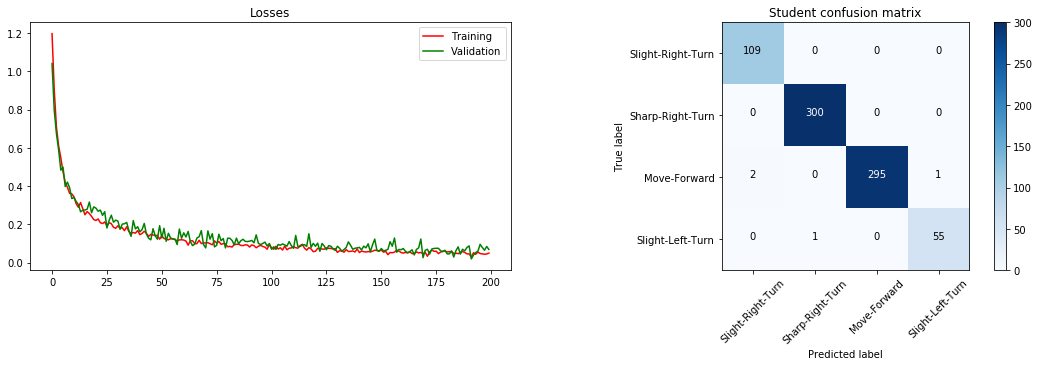


 ( Micro Averaging ) Accuracy: 99.4757536042

 ( Macro Averaging ) Accuracy: 99.4757536042
0.4438034076015728
0.11038835957978375
nan
[ 91 104 143 213 214 267 271 287 372 452 461 463 548 588 681 726 733]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  3   0 295   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

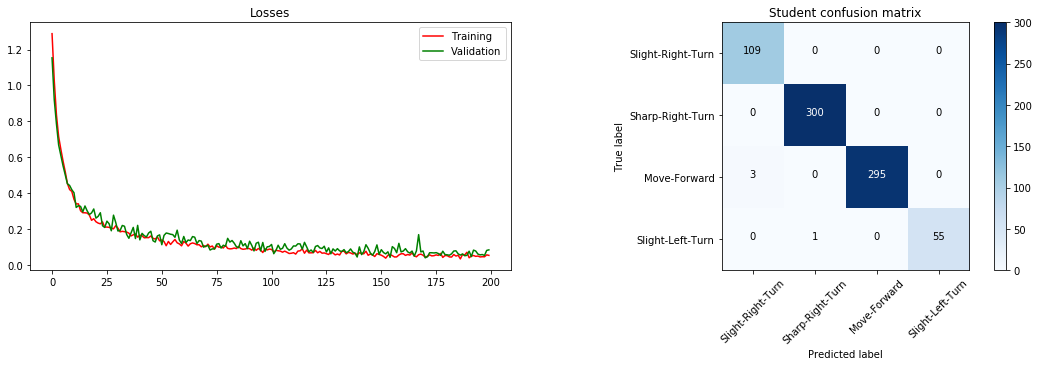


 ( Micro Averaging ) Accuracy: 99.6068152031

 ( Macro Averaging ) Accuracy: 99.6068152031
0.4400917431192661
0.10487550707975815
nan
[143 214 287]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  1   0 297   0]
 [  0   2   0  54]]


<Figure size 432x288 with 0 Axes>

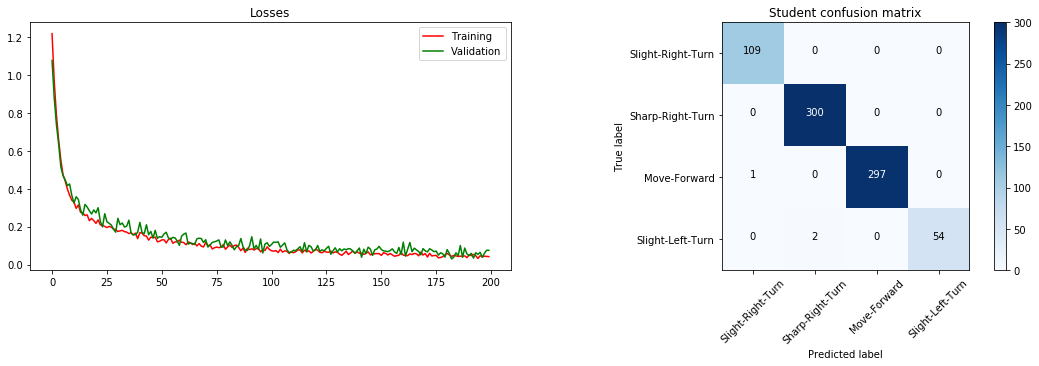


 ( Micro Averaging ) Accuracy: 98.9515072084

 ( Macro Averaging ) Accuracy: 98.9515072084
0.4338689384010485
0.09410337195640155
nan
[143 214 287]
Confusion matrix, without normalization
[[104   0   5   0]
 [  0 300   0   0]
 [  2   0 296   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

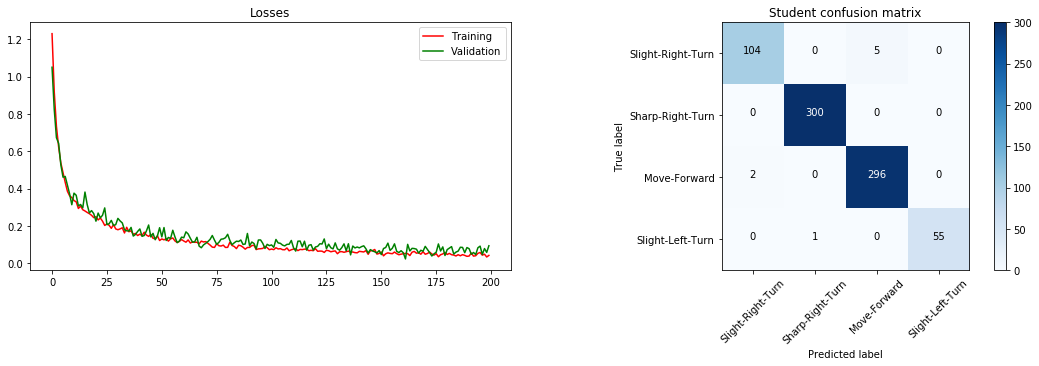


 ( Micro Averaging ) Accuracy: 99.4757536042

 ( Macro Averaging ) Accuracy: 99.4757536042
0.45638007863695934
0.10469450144436537
nan
[143 214 287 461]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  3   0 295   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

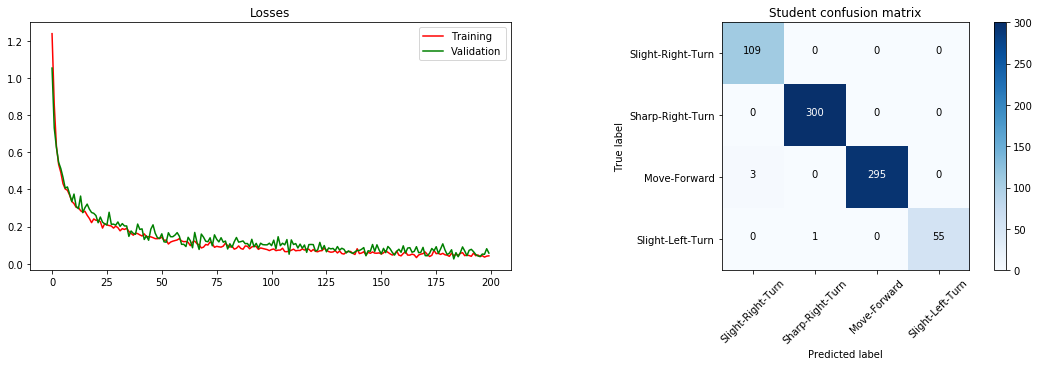


 ( Micro Averaging ) Accuracy: 99.2136304063

 ( Macro Averaging ) Accuracy: 99.2136304063
0.4440629095674967
0.09901146245033994
nan
[143 214 287 461]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  2   0 296   0]
 [  0   1   3  52]]


<Figure size 432x288 with 0 Axes>

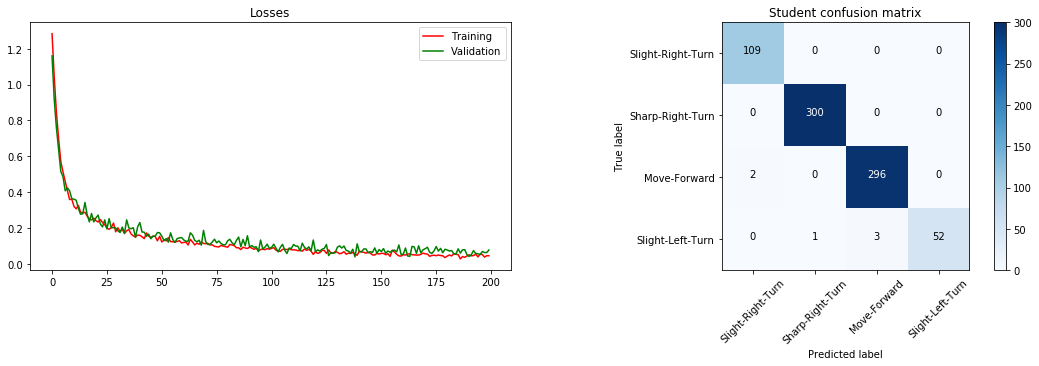


 ( Micro Averaging ) Accuracy: 99.3446920052

 ( Macro Averaging ) Accuracy: 99.3446920052
0.4387680209698558
0.09660281360071264
nan
[ 91 143 213 214 267 271 287 372 452 461 463 588 681 726 733]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  3   0 295   0]
 [  0   1   1  54]]


<Figure size 432x288 with 0 Axes>

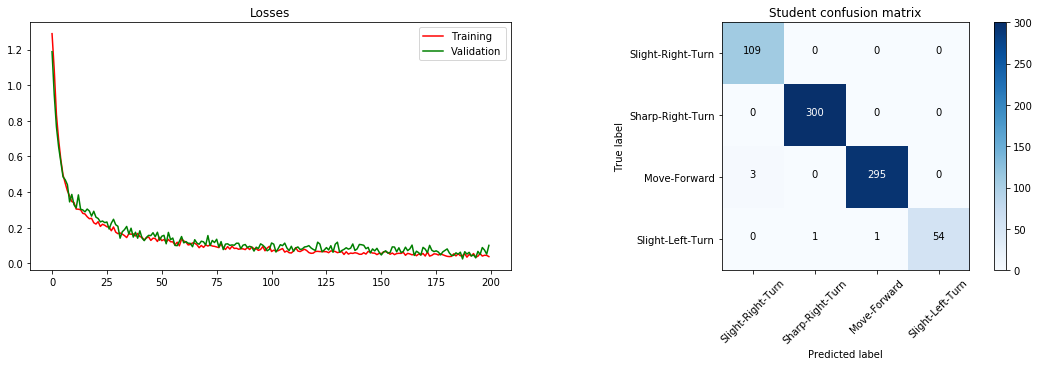


 ( Micro Averaging ) Accuracy: 99.0825688073

 ( Macro Averaging ) Accuracy: 99.0825688073
0.45047968545216255
0.10226106456191636
nan
[ 27  71  91 104 143 213 214 260 267 271 277 287 372 452 461 463 548 588
 658 681 726 733 734]
Confusion matrix, without normalization
[[106   2   1   0]
 [  0 300   0   0]
 [  2   1 294   1]
 [  0   0   0  56]]


<Figure size 432x288 with 0 Axes>

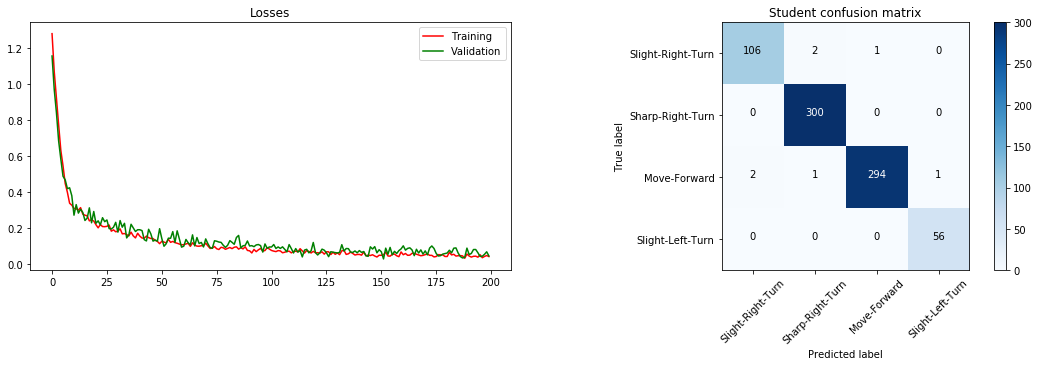


 ( Micro Averaging ) Accuracy: 99.3446920052

 ( Macro Averaging ) Accuracy: 99.3446920052
0.4424036697247707
0.0984087102847518
nan
[143 214 287]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  4   0 294   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

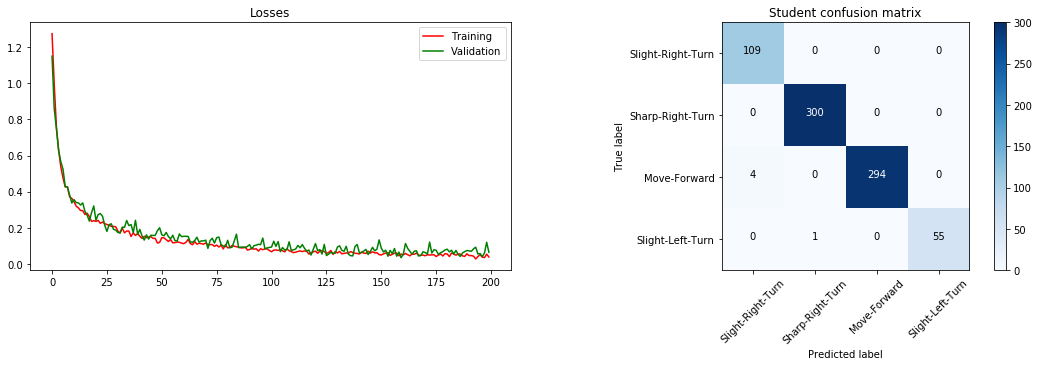


 ( Micro Averaging ) Accuracy: 99.3446920052

 ( Macro Averaging ) Accuracy: 99.3446920052
0.44422280471821757
0.09487001111591783
nan
[ 91 143 213 214 267 287 372 452 461 463 726 733]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  3   0 294   1]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

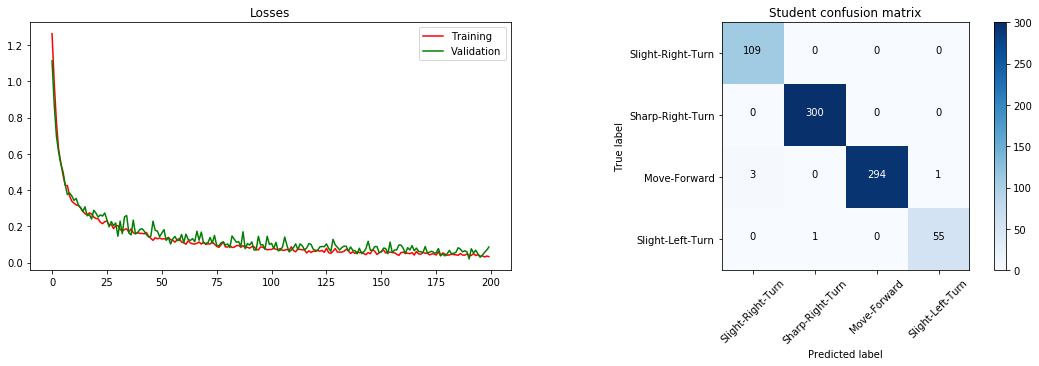


 ( Micro Averaging ) Accuracy: 99.3446920052

 ( Macro Averaging ) Accuracy: 99.3446920052
0.43016775884665787
0.10199816542559183
nan
[143 214 287]
Confusion matrix, without normalization
[[106   0   3   0]
 [  0 299   1   0]
 [  1   0 297   0]
 [  0   0   0  56]]


<Figure size 432x288 with 0 Axes>

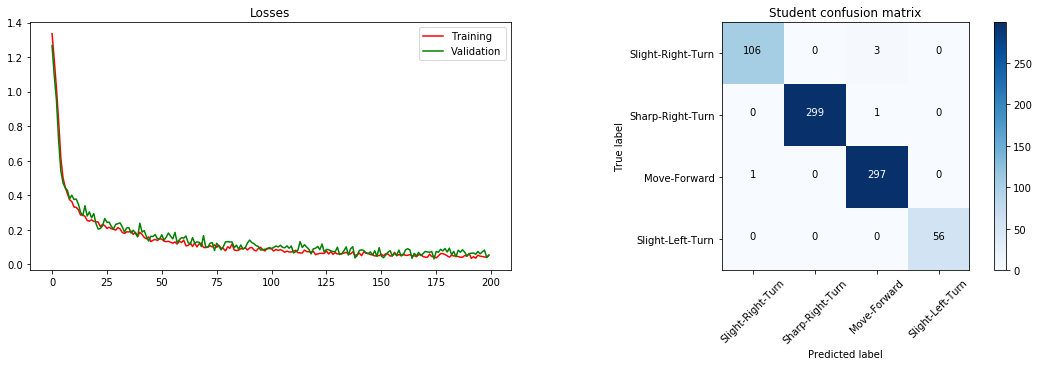


 ( Micro Averaging ) Accuracy: 99.2136304063

 ( Macro Averaging ) Accuracy: 99.2136304063
0.4470773263433814
0.1083864184538315
nan
[ 91 104 143 213 214 267 271 277 287 359 372 452 461 463 548 588 669 681
 721 726 733]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  5   0 293   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

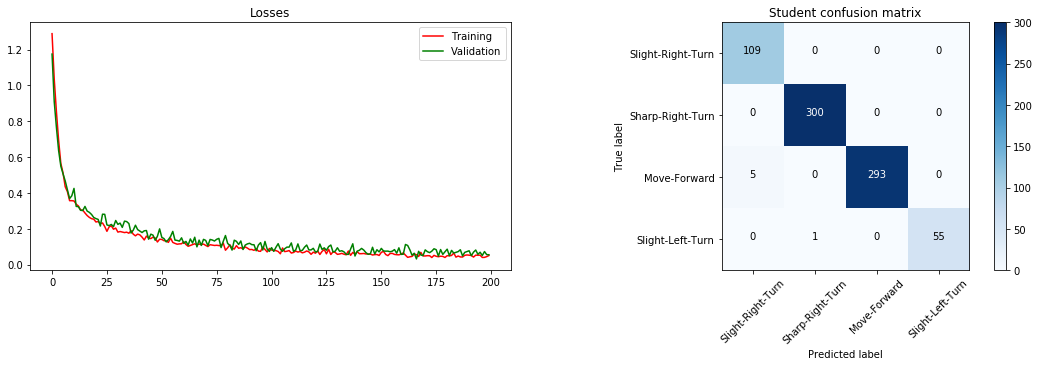


 ( Micro Averaging ) Accuracy: 99.6068152031

 ( Macro Averaging ) Accuracy: 99.6068152031
0.4481520314547838
0.09533411428469037
nan
[ 91 143 214 267 287 372 452 461 463 726 733]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  2   0 296   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

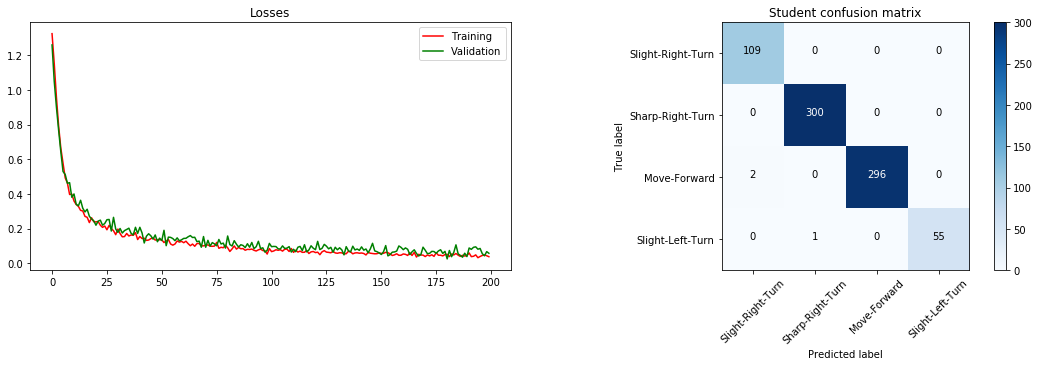


 ( Micro Averaging ) Accuracy: 99.3446920052

 ( Macro Averaging ) Accuracy: 99.3446920052
0.4410196592398427
0.10479493347407949
nan
[143 214 287 461]
Confusion matrix, without normalization
[[107   2   0   0]
 [  0 300   0   0]
 [  2   0 296   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

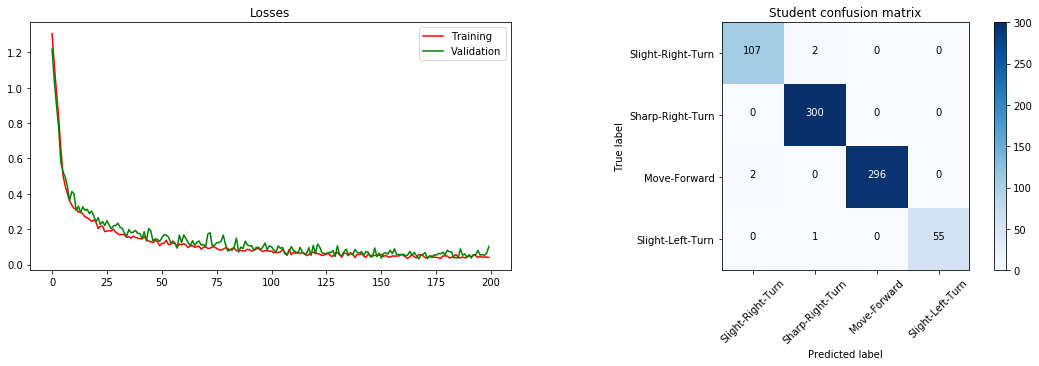


 ( Micro Averaging ) Accuracy: 99.6068152031

 ( Macro Averaging ) Accuracy: 99.6068152031
0.4350511140235911
0.09943584877104153
0.0413324398575729
[]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  2   0 296   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

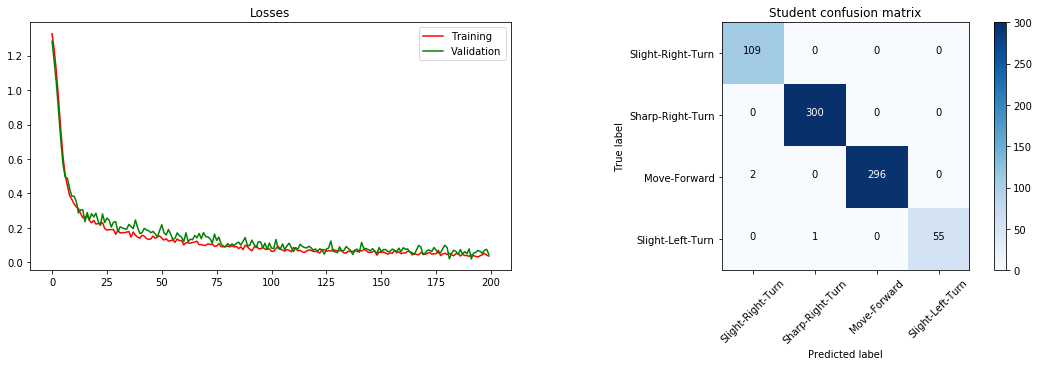


 ( Micro Averaging ) Accuracy: 99.4757536042

 ( Macro Averaging ) Accuracy: 99.4757536042
0.4367863695937091
0.10470749041356078
nan
[461]
Confusion matrix, without normalization
[[108   0   1   0]
 [  0 299   1   0]
 [  0   0 297   1]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

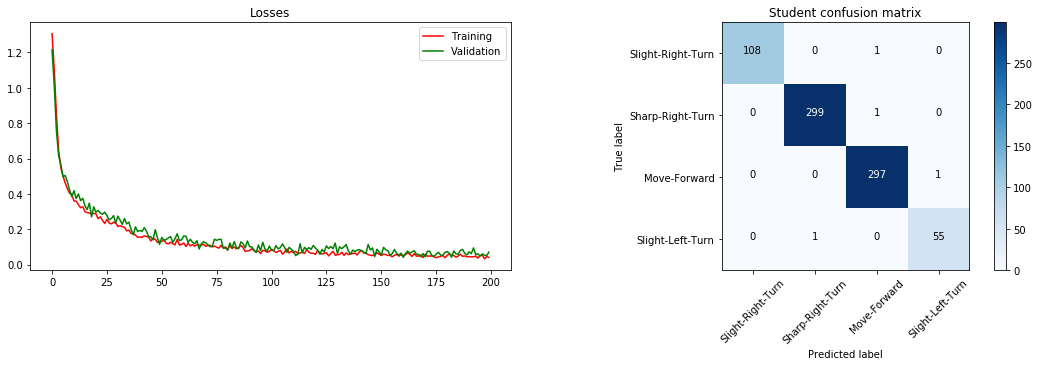


 ( Micro Averaging ) Accuracy: 99.0825688073

 ( Macro Averaging ) Accuracy: 99.0825688073
0.4377116644823067
0.09496706341384747
nan
[ 22  91 104 143 213 214 260 267 271 277 287 359 372 452 461 463 548 588
 658 669 681 721 726 733 734 748]
Confusion matrix, without normalization
[[107   2   0   0]
 [  0 300   0   0]
 [  3   0 294   1]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

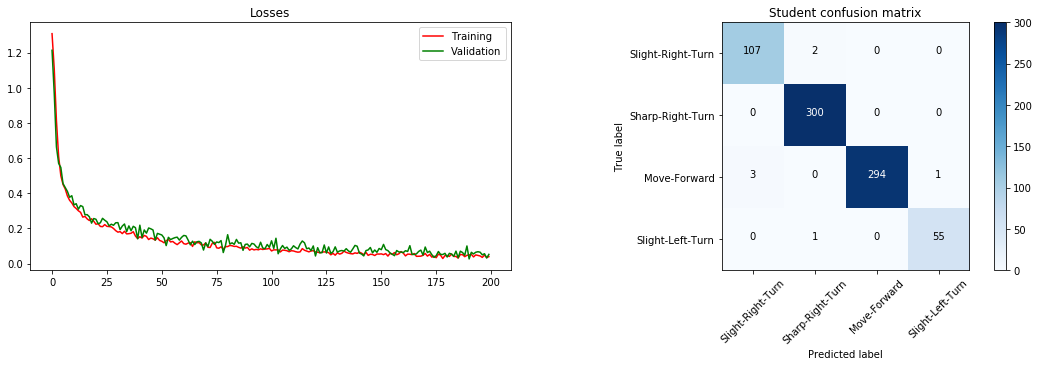


 ( Micro Averaging ) Accuracy: 99.0825688073

 ( Macro Averaging ) Accuracy: 99.0825688073
0.4446474442988204
0.09826332182278015
nan
[ 27  71  72 130 143 178 189 214 260 277 287 369 477 519 593 657 658 734]
Confusion matrix, without normalization
[[104   0   5   0]
 [  0 300   0   0]
 [  1   0 296   1]
 [  0   0   0  56]]


<Figure size 432x288 with 0 Axes>

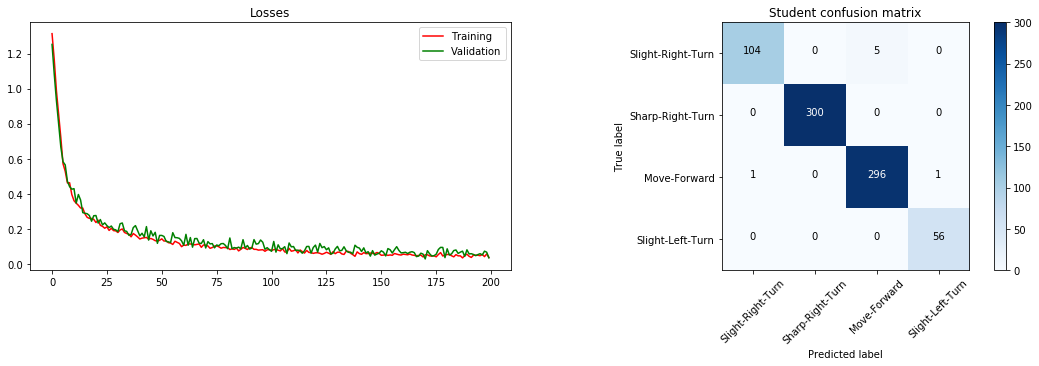


 ( Micro Averaging ) Accuracy: 99.6068152031

 ( Macro Averaging ) Accuracy: 99.6068152031
0.44018872870249015
0.10526032654048574
nan
[143 214 287]
Confusion matrix, without normalization
[[108   0   1   0]
 [  0 300   0   0]
 [  0   0 297   1]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

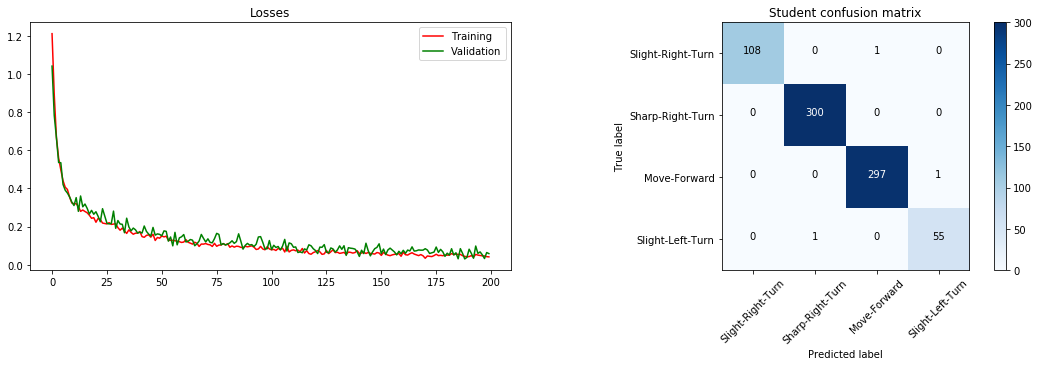


 ( Micro Averaging ) Accuracy: 99.2136304063

 ( Macro Averaging ) Accuracy: 99.2136304063
0.437653997378768
0.10073638556044193
nan
[143 214 287 461]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  4   0 294   0]
 [  0   1   1  54]]


<Figure size 432x288 with 0 Axes>

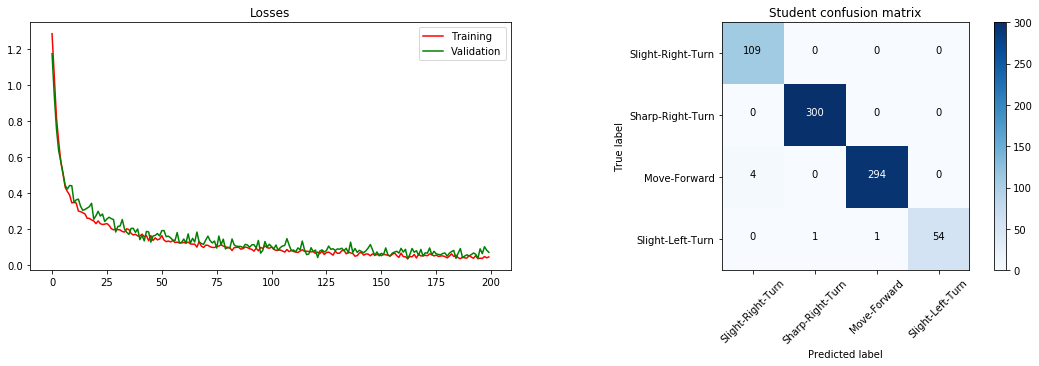


 ( Micro Averaging ) Accuracy: 99.0825688073

 ( Macro Averaging ) Accuracy: 99.0825688073
0.44343905635648756
0.10454578324664154
nan
[143 214 287]
Confusion matrix, without normalization
[[107   2   0   0]
 [  0 300   0   0]
 [  2   1 294   1]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

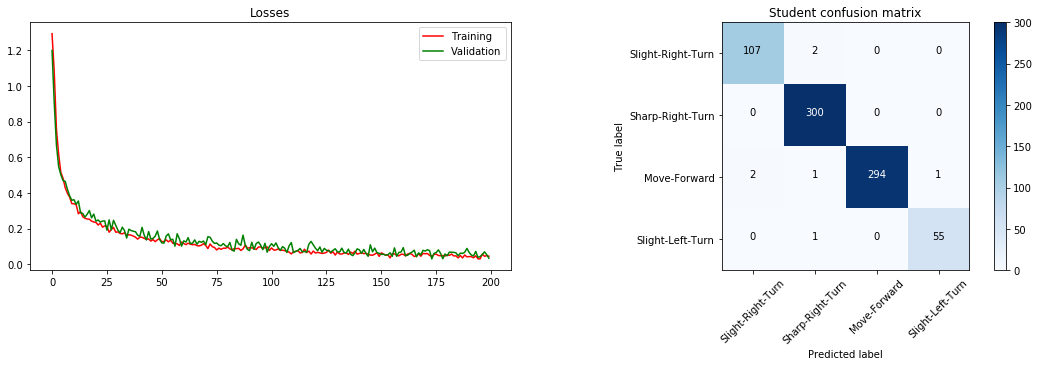


 ( Micro Averaging ) Accuracy: 99.7378768021

 ( Macro Averaging ) Accuracy: 99.7378768021
0.4413499344692005
0.10075734389718832
nan
[  2  15  22  27  71  72  91 104 119 130 143 175 178 189 213 214 219 259
 260 267 271 277 287 358 359 369 372 450 452 461 463 476 477 514 519 548
 588 593 631 657 658 669 681 699 721 726 731 733 734 748]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  1   0 296   1]
 [  0   0   0  56]]


<Figure size 432x288 with 0 Axes>

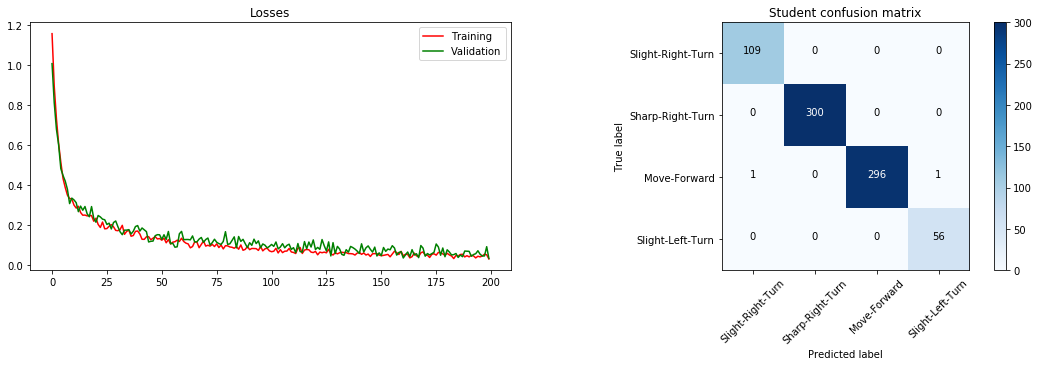


 ( Micro Averaging ) Accuracy: 99.2136304063

 ( Macro Averaging ) Accuracy: 99.2136304063
0.4379921363040629
0.10184473760162394
nan
[ 91 104 143 213 214 267 271 287 359 372 452 461 463 548 588 669 681 721
 726 733]
Confusion matrix, without normalization
[[107   2   0   0]
 [  0 300   0   0]
 [  2   1 295   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

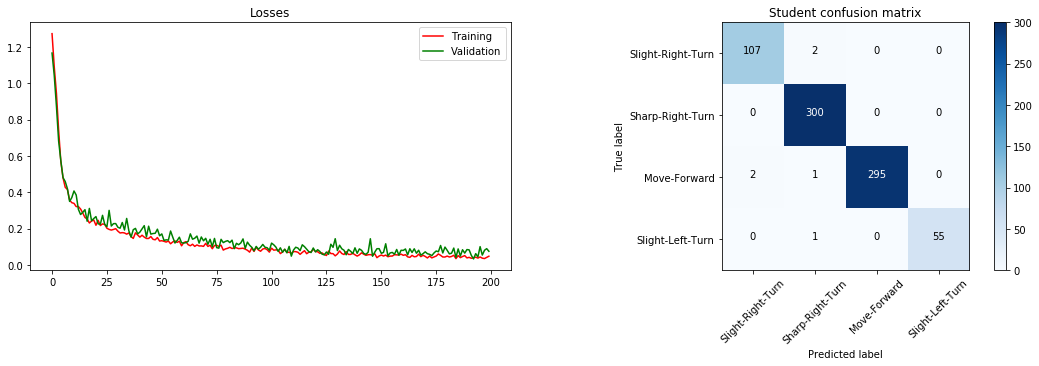


 ( Micro Averaging ) Accuracy: 99.2136304063

 ( Macro Averaging ) Accuracy: 99.2136304063
0.43768807339449534
0.10244922962913663
nan
[ 91 104 143 213 214 267 271 287 359 372 452 461 463 548 588 669 681 721
 726 733]
Confusion matrix, without normalization
[[107   2   0   0]
 [  0 300   0   0]
 [  2   1 294   1]
 [  0   0   0  56]]


<Figure size 432x288 with 0 Axes>

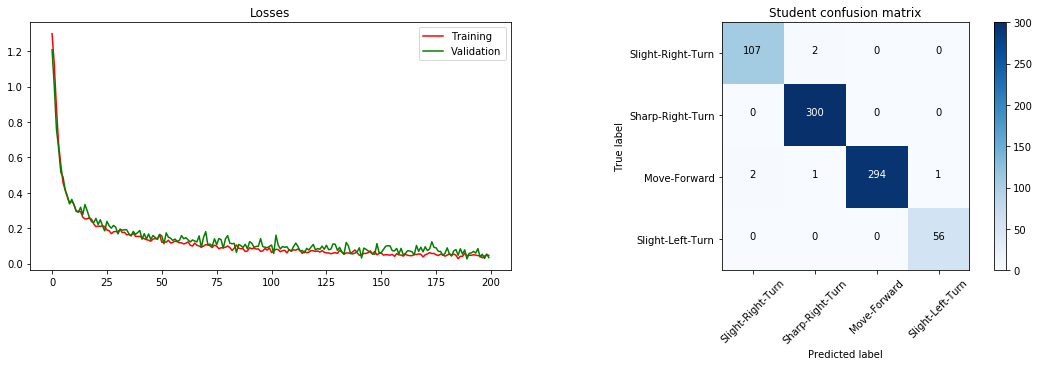


 ( Micro Averaging ) Accuracy: 99.2136304063

 ( Macro Averaging ) Accuracy: 99.2136304063
0.44176933158584525
0.09485896199277626
nan
[143 214 287]
Confusion matrix, without normalization
[[107   0   2   0]
 [  0 300   0   0]
 [  2   0 295   1]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

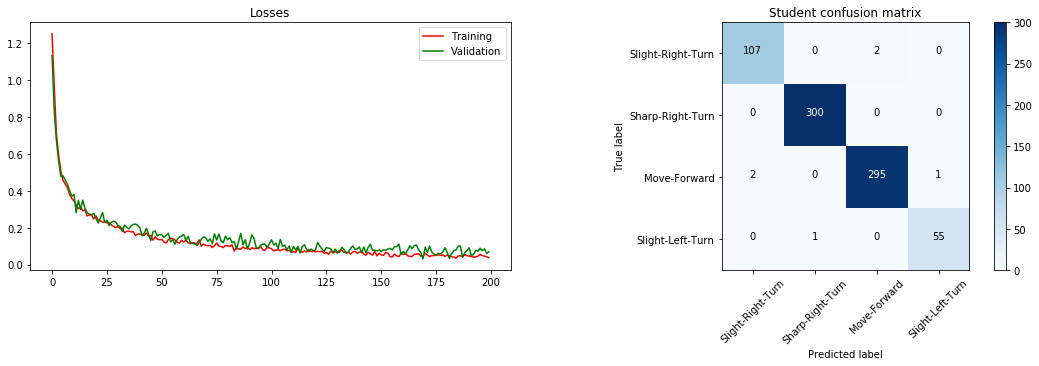


 ( Micro Averaging ) Accuracy: 99.868938401

 ( Macro Averaging ) Accuracy: 99.868938401
0.44026212319790303
0.10280962102847518
nan
[ 91 104 143 213 214 267 271 287 359 372 452 461 463 548 588 658 669 681
 721 726 733 734]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  1   0 297   0]
 [  0   0   0  56]]


<Figure size 432x288 with 0 Axes>

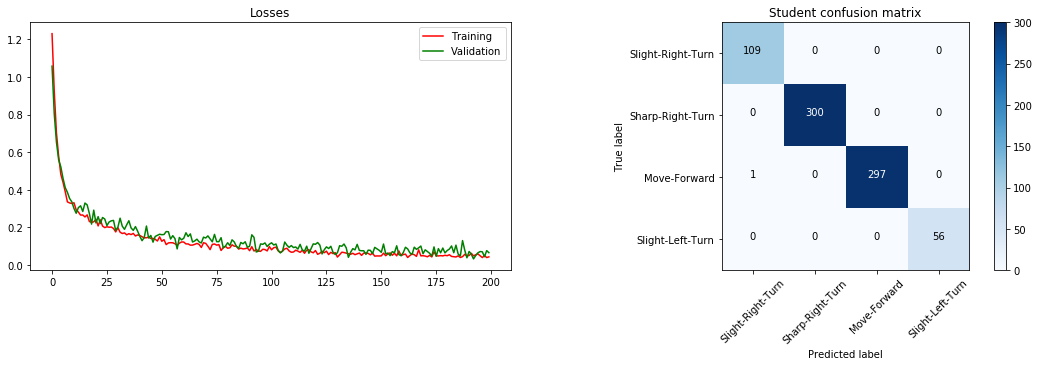


 ( Micro Averaging ) Accuracy: 99.0825688073

 ( Macro Averaging ) Accuracy: 99.0825688073
0.44064220183486236
0.10741889523647404
nan
[143 214 287 461]
Confusion matrix, without normalization
[[104   2   3   0]
 [  0 300   0   0]
 [  0   0 297   1]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

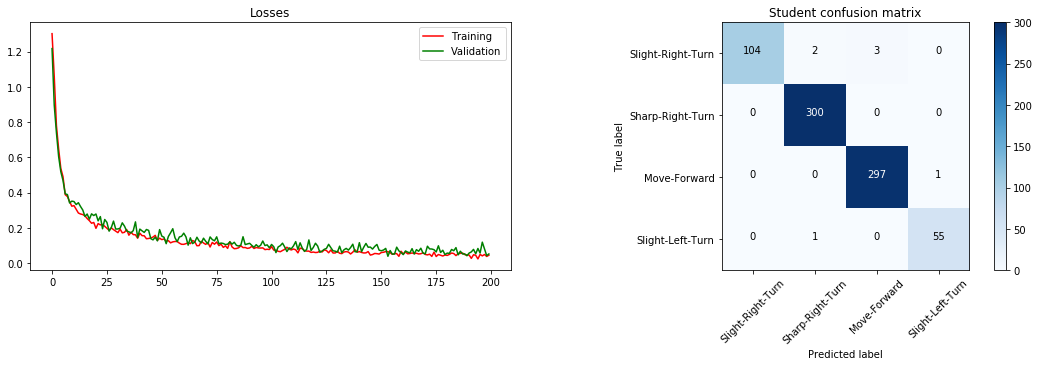


 ( Micro Averaging ) Accuracy: 98.6893840105

 ( Macro Averaging ) Accuracy: 98.6893840105
0.4407287024901703
0.09622656345992382
nan
[143 214 287]
Confusion matrix, without normalization
[[101   2   6   0]
 [  0 300   0   0]
 [  0   0 297   1]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

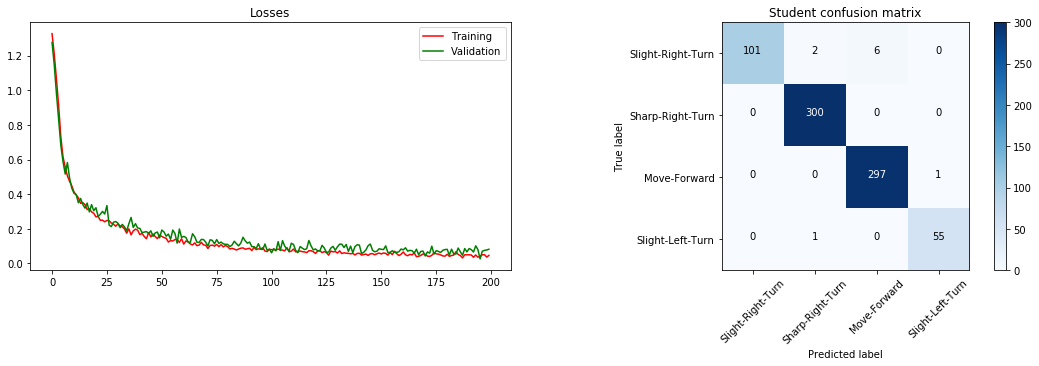


 ( Micro Averaging ) Accuracy: 99.4757536042

 ( Macro Averaging ) Accuracy: 99.4757536042
0.43806290956749666
0.10493221257960968
nan
[ 91 143 213 452 461 681 733]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  3   0 295   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

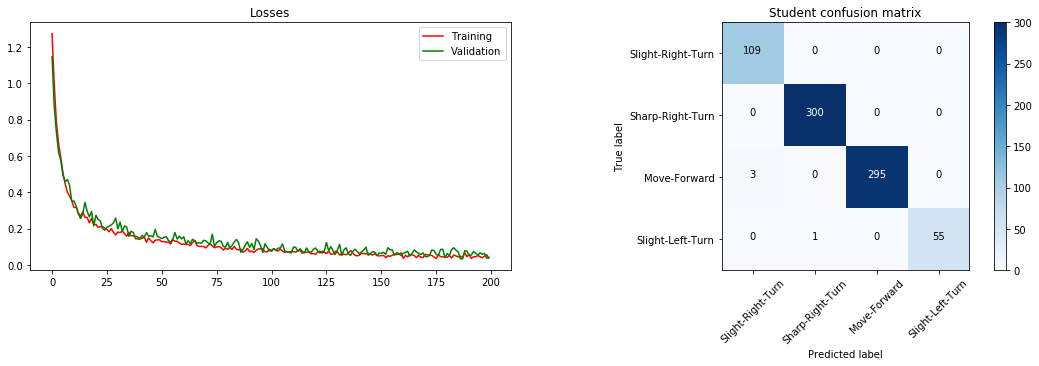


 ( Micro Averaging ) Accuracy: 99.3446920052

 ( Macro Averaging ) Accuracy: 99.3446920052
0.44082044560943645
0.11850741525152564
nan
[143 214 277 287 461]
Confusion matrix, without normalization
[[106   0   3   0]
 [  0 300   0   0]
 [  1   0 297   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

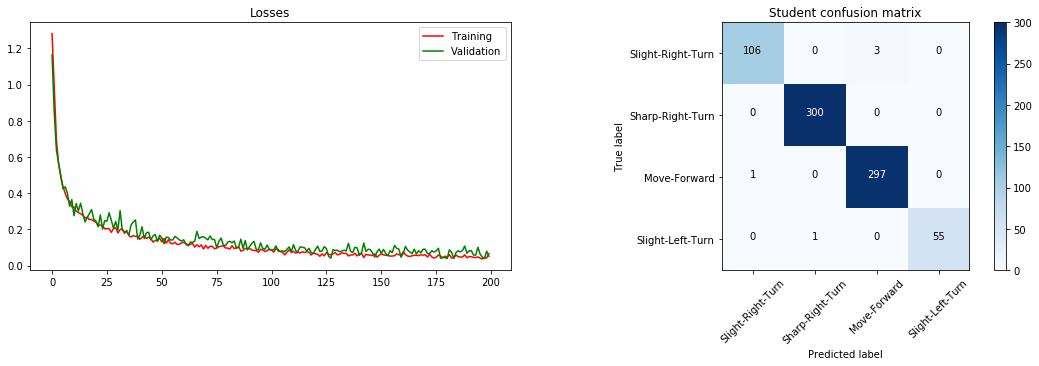


 ( Micro Averaging ) Accuracy: 99.0825688073

 ( Macro Averaging ) Accuracy: 99.0825688073
0.4423695937090433
0.1082271310948763
nan
[461]
Confusion matrix, without normalization
[[105   2   2   0]
 [  0 300   0   0]
 [  1   0 296   1]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

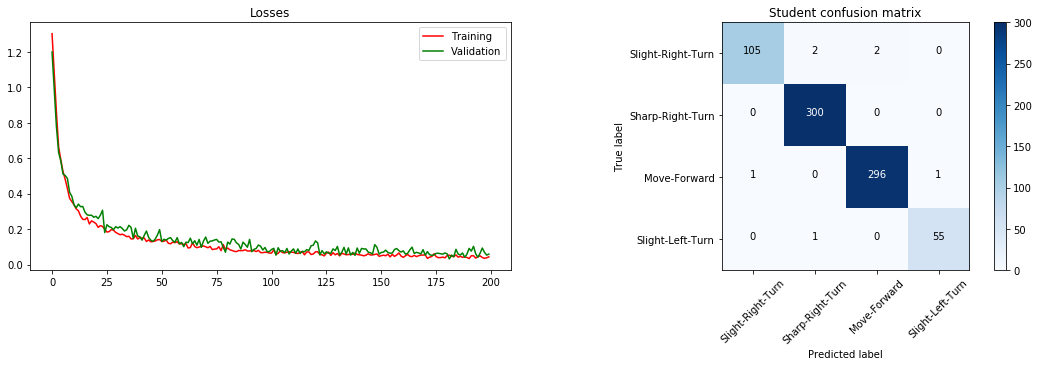


 ( Micro Averaging ) Accuracy: 99.4757536042

 ( Macro Averaging ) Accuracy: 99.4757536042
0.4407758846657929
0.10576502648749796
nan
[143 214 287 461]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  2   0 295   1]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

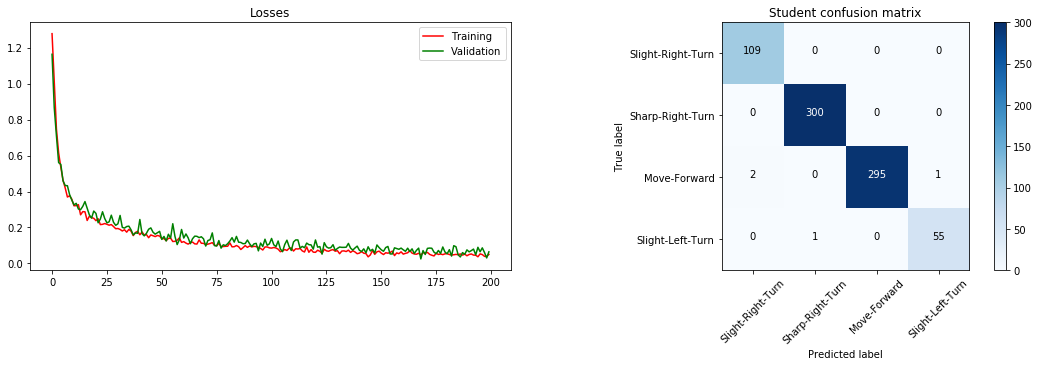


 ( Micro Averaging ) Accuracy: 99.3446920052

 ( Macro Averaging ) Accuracy: 99.3446920052
0.4452634338138925
0.11031257559400086
nan
[ 27  71 143 214 260 277 287 461 658 734]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  3   0 294   1]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

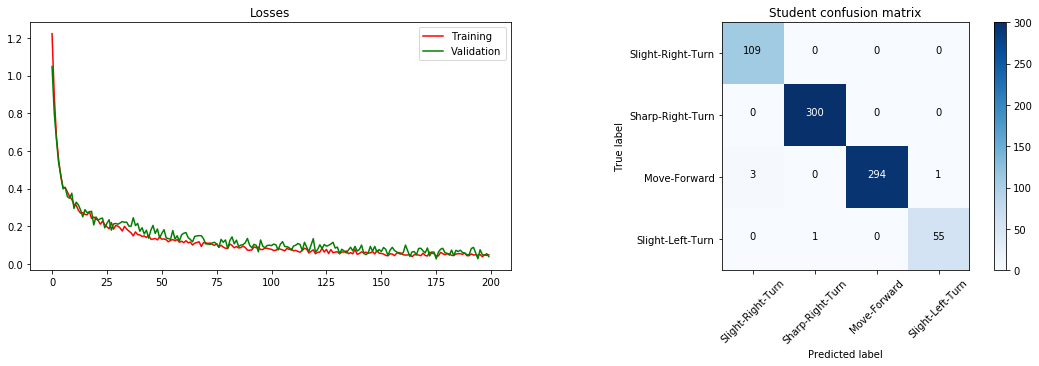


 ( Micro Averaging ) Accuracy: 99.4757536042

 ( Macro Averaging ) Accuracy: 99.4757536042
0.4386290956749673
0.10264412416230648
0.04379166469348992
[]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  2   0 295   1]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

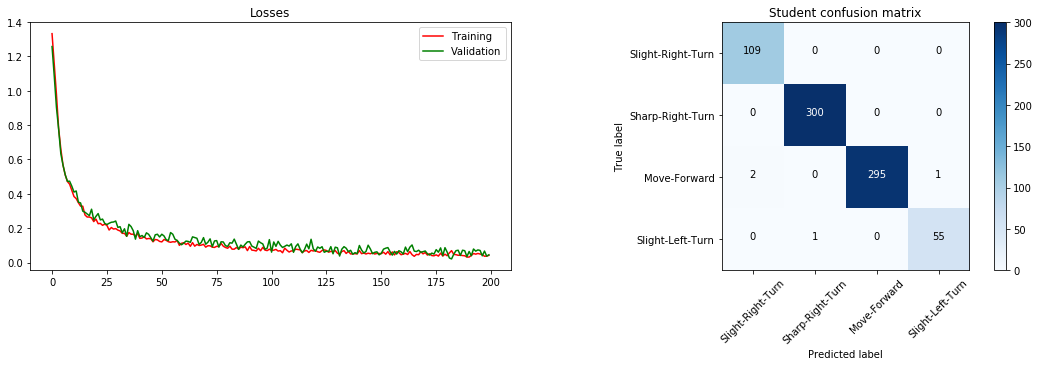


 ( Micro Averaging ) Accuracy: 99.4757536042

 ( Macro Averaging ) Accuracy: 99.4757536042
0.4393656618610747
0.10018130961126925
nan
[ 27  71 143 214 260 277 287 658 734]
Confusion matrix, without normalization
[[109   0   0   0]
 [  0 300   0   0]
 [  2   0 296   0]
 [  0   1   1  54]]


<Figure size 432x288 with 0 Axes>

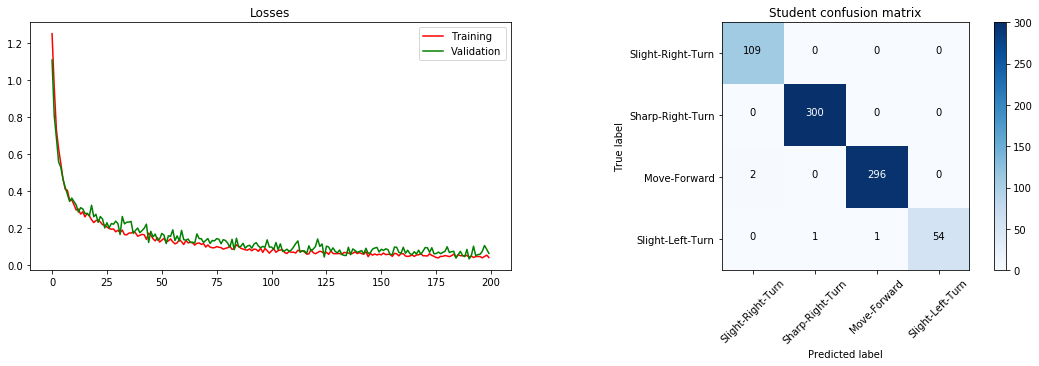


 ( Micro Averaging ) Accuracy: 99.3446920052

 ( Macro Averaging ) Accuracy: 99.3446920052
0.43410484927916126
0.09336579049086664
nan
[ 15  27  71  72 130 143 178 189 214 260 277 287 369 477 519 593 657 658
 734]
Confusion matrix, without normalization
[[108   1   0   0]
 [  0 300   0   0]
 [  3   0 295   0]
 [  0   1   0  55]]


<Figure size 432x288 with 0 Axes>

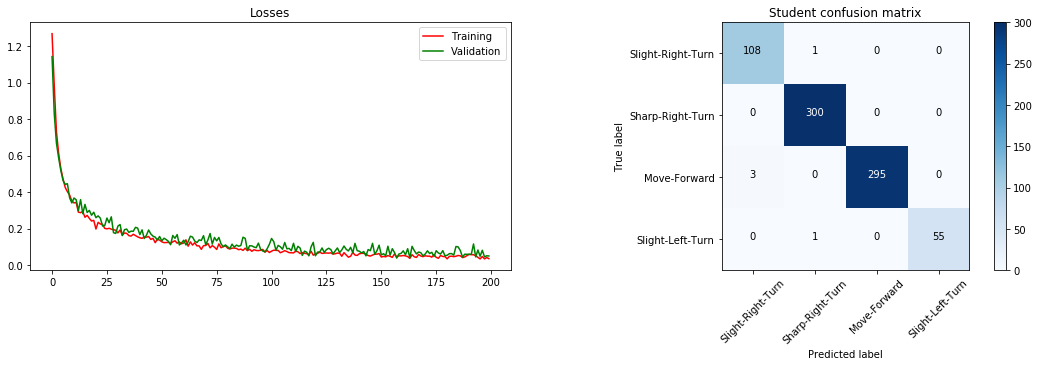

Epoch - Mean accuracy - Accuracy standard deviation - Dropout probabilities per layer   -   Mean Variation ratio  -  Mean Predictive Entropy  -  Mean Mutual Information
200 - 99.3551769331586     0.03163773791793357      [0.01057034 0.06590679 0.04614985 0.02265023]  -  0.44072681520314555  -  0.10235628900490458  -  nan


In [7]:
results = []

# get results for multiple N
#for N, nb_epoch in zip(Ns, nb_epochs):
for nb_epoch in nb_epochs:
       
    # repeat exp multiple times
    rep_results = []
    for i in xrange(nb_reps):
        X_train, Y_train = X_tr, Y_tr
        X_val, Y_val = X_v, Y_v
        hist, model, ELBO = fit_model(nb_epoch, X_train, Y_train, validation_data=(X_val, Y_val))
        valid_loss_hist = hist.history['val_loss']
        train_loss_hist = hist.history['loss']
       
    
        """
        Get uncertainty metrics.
        
        Variation ratio = 1 - majority_class/(total number of samples)
        Predictive entropy = -Sum_c( p(y==c|D)log( p(y==c|D) ) )
        Mutual Information = PredictiveEntropy - E[ PredictiveEntropy ]
        """
        MC_samples = np.array([model.predict(X_val) for _ in range(K_test)])
        acc, acc_maj_vote, MC_means, MC_pred, mode_fx = test(Y_val, MC_samples)  
        
              
        #Average variation ratio over the minibatch
        variation_ratio = np.zeros(MC_pred.shape)
        for j in xrange(len(MC_pred)):
            variation_ratio[j] = 1 - ((mode_fx[j])[1])/float(K_test)
        variation_ratio_avg_VR = np.sum(variation_ratio)/float(len(MC_pred))
        print(variation_ratio_avg_VR)
       
        #Average predictive entropy over minibatch
        predictive_entropy = -1*np.sum(MC_means*np.log(MC_means),axis=-1)
        predictive_entropy_avg_H = np.sum(predictive_entropy)/float(len(MC_pred))
        print(predictive_entropy_avg_H)
        
        #Average mutual information over minibatch
        expected_entropy = np.sum(np.sum(MC_samples*np.log(MC_samples),axis=-1),axis=0)/float(K_test)
        mutual_information_avg_MI = predictive_entropy_avg_H + np.sum(expected_entropy)/float(len(MC_pred))
        print(mutual_information_avg_MI)
        
              
        ps = np.array([K.eval(layer.p) for layer in model.layers if hasattr(layer, 'p')])
              
        """
        Save best model weights
        """
        if not np.argwhere(np.isnan(predictive_entropy)).size:
            id = np.argwhere(np.isnan(expected_entropy))
            print(id.flatten())
            if not id.size:
                expected_entropy[id.flatten()] = 1.0
                mutual_information_avg_MI = predictive_entropy_avg_H + np.sum(expected_entropy)/float(len(MC_pred))
            if rep_results!=[]:
                if acc>rep_results[-1][0]:
                   model.save_weights('/home/yannis/Desktop/compress_bnn/DNN_model/DNN_weights.h5') 
            else:
                model.save_weights('/home/yannis/Desktop/compress_bnn/DNN_model/DNN_weights.h5')

            rep_results += [(acc, acc_maj_vote, ps, variation_ratio_avg_VR, predictive_entropy_avg_H, mutual_information_avg_MI )]
            plot(range(nb_epoch),train_loss=train_loss_hist,valid_loss=valid_loss_hist,valid_y=Y_val,preds=MC_pred)
    
    test_mean = np.mean([r[0] for r in rep_results])
    test_std_err = np.std([r[0] for r in rep_results]) / np.sqrt(nb_reps)
    ps = np.mean([r[2] for r in rep_results], 0)
    VR_avg = np.mean([r[3] for r in rep_results])
    H_avg = np.mean([r[4] for r in rep_results])
    MI_avg = np.mean([r[5] for r in rep_results])
    print("Epoch - Mean accuracy - Accuracy standard deviation - Dropout probabilities per layer   -   Mean Variation ratio  -  Mean Predictive Entropy  -  Mean Mutual Information")
    print nb_epoch, '-', test_mean, '   ', test_std_err, '    ',ps, ' - ', VR_avg, ' - ', H_avg, ' - ',MI_avg
    sys.stdout.flush()
    results += [rep_results]
    



In [ ]:
"""
#KeplerMapper
from kmapper import jupyter
import kmapper as km
from sklearn import metrics, cluster, preprocessing

predict_penultimate_layer =  K.function([model.layers[0].input, K.learning_phase()], [model.layers[-2].output])
X_inverse_test = np.array(predict_penultimate_layer([X_v, 1]))[0]
print((X_inverse_test.shape, "X_inverse_valid shape"))

X_projected_test = np.c_[np.argmax(Y_v,axis=-1),variation_ratio, predictive_entropy, predictive_entropy+expected_entropy]
print((X_projected_test.shape, "X_projected_valid shape"))

mapper = km.KeplerMapper(verbose=0)
G = mapper.map(X_projected_test,
               X_inverse_test, 
               clusterer=cluster.AgglomerativeClustering(n_clusters=2),
               overlap_perc=0.9,
               nr_cubes=10)

color_function_output = predictive_entropy+expected_entropy

_ = mapper.visualize(G,
                 projected_X=X_projected_test,
                 projected_X_names=["Variation Ratio", "Predictive Entropy", "Mutual Information"],
                 color_function=color_function_output,
                 title="Confidence Graph for an MLP trained on Obstacle Avoidance dataset")

jupyter.display("mapper_visualization_output.html")
"""

In [ ]:
import pickle
with open('./concrete-dropout.pkl', 'wb') as f:
    pickle.dump(results, f)

In [ ]:
# import pickle
# with open('concrete-dropout.pkl', 'rb') as f:
#     results = pickle.load(f)

In [ ]:
best_tests = np.array([[r[0] for r in result] for result in results]).T
best_ps = np.array([[r[1] for r in result] for result in results])
best_epistemic_uncertainty = np.array([[r[2] for r in result] for result in results]).T.squeeze()
print best_tests.mean(0)
print best_ps.mean(1)

In [ ]:
import pylab
%matplotlib inline

pylab.figure(figsize=(3, 3))
pylab.plot(N, np.mean(best_epistemic_uncertainty, 0)**0.5, '-*')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Epistemic uncertainty (std)')
pylab.xscale('log')
pylab.savefig('epistemic.pdf', bbox_inches='tight')
pylab.show()

pylab.figure(figsize=(3, 3))
predictive = np.mean(best_epistemic_uncertainty, 0) + np.mean(best_aleatoric_uncertainty, 0)
pylab.plot(N, predictive**0.5, '-*')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Predictive uncertainty (std)')
pylab.ylim([0, 2])
pylab.xscale('log')
pylab.savefig('predictive.pdf', bbox_inches='tight')
pylab.show()

In [ ]:
pylab.figure(figsize=(3, 1.5))
ps = best_ps.mean(1)
ps_std = best_ps.std(1)
for i, (p, p_std) in enumerate(zip(ps.T, ps_std.T)):
    if i == 4:
        continue  # layer 4 is noise layer
    pylab.plot(N, p, '-*', label='Layer #' + str(i+1))
#     pylab.fill_between(Ns, p + p_std, p - p_std, alpha=0.25)
pylab.legend(bbox_to_anchor=(1, 0), loc='lower left')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Dropout probability')
pylab.xscale('log')
pylab.savefig('dropout_prob.pdf', bbox_inches='tight')
pylab.show()